#Mount device#

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd drive/MyDrive

/content/drive/MyDrive


In [3]:
!pwd

/content/drive/MyDrive


#Import#

In [4]:
from collections import Counter
import re
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook
import tensorflow as tf

import nltk

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn

#Define Constants#

In [5]:
MAX_NB_WORDS = 100000    # max no. of words for tokenizer
MAX_SEQUENCE_LENGTH = 100 # max length of each entry (sentence), including padding
EMBEDDING_DIM = 100      # embedding dimensions for word vectors (word2vec/GloVe)
GLOVE_DIR = "glove.6B."+str(EMBEDDING_DIM)+"d.txt"

#Load Data#

In [6]:
train = pd.read_csv('BALANCED.csv') #dataset
y = train['period'].values
lyrics_train = train['lyrics']
lyrics_train = list(lyrics_train)

labels = [60, 70, 80, 90, 0, 10]

In [7]:
print(len(lyrics_train))

25078


In [8]:
texts = [] 

for line in tqdm_notebook(lyrics_train, total=59): 
    if type(line) != float:
      texts.append(line)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


  0%|          | 0/59 [00:00<?, ?it/s]

In [9]:
print('Sample data:', texts[753], y[753])

Sample data: read news today oh boy lucky man made grade though news rather sad well laugh saw photograph blew mind car notice light changed crowd people stood stared seen face nobody really sure house lord 60.0


#Tokenize#

In [10]:
for i, ex in enumerate(texts):
  if (type(ex) == float):
    print(i, ex)

In [11]:
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
word_index = tokenizer.word_index
print('Vocabulary size:', len(word_index))

Vocabulary size: 38596


#Padding#

In [12]:
data = pad_sequences(sequences, padding = 'pre', maxlen = MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', y.shape)

Shape of data tensor: (25062, 100)
Shape of label tensor: (25078,)


In [13]:
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = y[indices]

In [14]:
print(labels)
# convert to one hot encoding 
one_hot_labels = []
for lab in labels:
  lab_arr = [0, 0, 0, 0, 0, 0] #60, 70, 80, 90, 0, 10
  if lab > 50:
    lab_arr[int((lab - 60) / 10)] = 1
  elif lab == 0:
    lab_arr[4] = 1
  else:
    lab_arr[5] = 1

  one_hot_labels.append(lab_arr)

one_hot_labels = np.array(one_hot_labels)
print(one_hot_labels[0])

[60.  0. 60. ...  0. 90.  0.]
[1 0 0 0 0 0]


In [15]:
print('Tokenized sentences: \n', data[1])
print('Label: \n', labels[1], one_hot_labels[1])

Tokenized sentences: 
 [  274  3270    43     3     3   171  1041   179   179   201   184     9
   179   179   201   184     9   179   179   201   184     9   179   179
   201   184     9  8241   183    31   670   630  5703   184  1140    27
   789    67  1564    27    10  4613   250  8241  1065     1   323  1065
  1026  2544   160  1210 12356  1242  4355    24  2977    28  8241    53
  3192   364   108   418   582  2490    20     9  2511   364   134    31
     7   582   582     7   582    53   315   572    15   220     3     4
  3810   186   184     4  5018  2751   164    53 10364 20339   125   930
  8193  3462    15   601]
Label: 
 0.0 [0 0 0 0 1 0]


In [16]:
print(data.shape)
print(one_hot_labels.shape)

(25062, 100)
(25062, 6)


#GloVe#

In [17]:
# run one time to get the glove files - recomment after running
#!wget http://nlp.stanford.edu/data/glove.6B.zip
#!unzip glove*.zip

In [18]:
embeddings_index = {}
f = open(GLOVE_DIR)
print('Loading GloVe from:', GLOVE_DIR,'...', end='')
for line in f:
    values = line.split()
    word = values[0]
    embeddings_index[word] = np.asarray(values[1:], dtype='float32')
f.close()
print("Done.\n Proceeding with Embedding Matrix...", end="")

embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
print(" Completed!")

Loading GloVe from: glove.6B.100d.txt ...Done.
 Proceeding with Embedding Matrix... Completed!


In [19]:
print(embedding_matrix)
print(embedding_matrix.shape)

[[ 0.02678852  0.56718693  0.91813412 ...  0.83030048  0.39614194
   0.6350992 ]
 [ 0.25975001  0.55833     0.57985997 ... -0.84028    -0.001562
   0.62222999]
 [ 0.19073001  0.56863999  0.72026998 ... -0.33460999  0.044349
   0.57541001]
 ...
 [-0.47727999  0.41286001 -0.25492999 ...  0.50187999  0.49013999
  -0.036587  ]
 [-0.26133001 -0.2516     -0.2342     ...  0.16856     0.32512999
   0.30544999]
 [-0.81522     0.22296999 -0.20534    ...  0.41111001  0.96516001
   0.045773  ]]
(38597, 100)


In [20]:
print(embeddings_index.get("oh"))

[-0.66665    0.43269    1.3134    -0.82401   -0.49119   -0.25539
  0.17218    0.096491   0.73471   -0.47311    0.84297   -0.17814
  0.06899    0.35398    0.79902   -0.5068    -0.73423    0.4316
 -0.19999    0.28445    0.61717    1.1017    -0.66268    0.046644
 -0.25004    1.0071    -0.69227   -0.56218    0.85816   -0.024464
 -0.0062941  0.5624     0.44646    0.3914    -0.44148   -0.16391
  0.28715    0.87507    0.10045   -0.85481    0.48092    0.41397
 -0.5398    -1.0613     0.053256  -0.18865   -0.31431   -0.22778
  0.2923    -0.18124   -0.74868   -0.033828   0.76007    0.251
 -1.7381    -0.96023    0.66813    0.84325    0.53863   -0.34752
  0.0060747  0.57681   -0.41687   -0.94694    0.2319     0.61614
  1.1121     0.91012   -1.1561     0.11259    0.16526    0.38187
 -0.25311   -0.77       0.24662    0.86771    0.48519   -0.50824
  0.0023807 -0.33348    0.71154   -0.022394   0.42365   -1.0359
 -1.4851    -0.010789  -0.68042   -0.63857    0.067217   0.85724
 -0.10916   -0.16433   -0.0

In [21]:
# Converting our labels into numpy arrays
lyrics = np.array(data)
labels = np.array(one_hot_labels)

In [22]:
print(lyrics[:20])
print(labels[:20])

[[   0    0    0 ... 1839 2269  107]
 [ 274 3270   43 ... 3462   15  601]
 [   0    0    0 ...  633  633  329]
 ...
 [   0    0    0 ...   62  214   53]
 [   0    0    0 ...  402  379   21]
 [   0    0    0 ...  364   34  364]]
[[1 0 0 0 0 0]
 [0 0 0 0 1 0]
 [1 0 0 0 0 0]
 [0 1 0 0 0 0]
 [0 0 0 1 0 0]
 [0 0 0 0 1 0]
 [0 1 0 0 0 0]
 [1 0 0 0 0 0]
 [0 0 0 1 0 0]
 [0 0 0 0 0 1]
 [0 0 0 1 0 0]
 [1 0 0 0 0 0]
 [0 0 0 0 1 0]
 [0 0 0 1 0 0]
 [0 0 0 1 0 0]
 [0 0 0 0 1 0]
 [0 0 0 1 0 0]
 [0 1 0 0 0 0]
 [1 0 0 0 0 0]
 [0 0 0 0 0 1]]


#Partition the Data (train, val, test)#

In [23]:
split_frac = 0.7 # 70% train, 30% test(val + test)
split_id = int(split_frac * len(lyrics))
train_lyrics, test_lyrics = lyrics[:split_id], lyrics[split_id:]
train_labels, test_labels = labels[:split_id], labels[split_id:]

In [24]:
print(train_labels.shape)
print(train_lyrics.shape)

(17543, 6)
(17543, 100)


In [25]:
split_frac = 0.5 # 50% validation, 50% test
split_id = int(split_frac * len(test_lyrics))
val_lyrics, test_lyrics = test_lyrics[:split_id], test_lyrics[split_id:]
val_labels, test_labels = test_labels[:split_id], test_labels[split_id:]

#Train Model

In [26]:
train_data = TensorDataset(torch.from_numpy(train_lyrics), torch.from_numpy(train_labels))
val_data = TensorDataset(torch.from_numpy(val_lyrics), torch.from_numpy(val_labels))
test_data = TensorDataset(torch.from_numpy(test_lyrics), torch.from_numpy(test_labels))

batch_size = 512
hidden = 128
epochs = 30
lr=0.0001
dropout=0.5

train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size, drop_last=True)
val_loader = DataLoader(val_data, shuffle=True, batch_size=batch_size, drop_last=True)
test_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size, drop_last=True)

In [27]:
# torch.cuda.is_available() checks and returns a Boolean True if a GPU is available, else it'll return False
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [28]:
class SentimentNet(nn.Module):
    def __init__(self,
                 weight_matrix=None,
                 vocab_size=None, 
                 output_size=1,  
                 hidden_dim=512, 
                 embedding_dim=400, 
                 n_layers=1,
                 dropout_prob=0.5):
        super(SentimentNet, self).__init__()
        self.output_size = output_size
        self.n_layers = n_layers
        # dimensions of our hidden state, what is passed from one time point to the next
        self.hidden_dim = hidden_dim
        # initialize the representation to pass to the LSTM
        self.embedding, embedding_dim = self.init_embedding(
            vocab_size, 
            embedding_dim, 
            weight_matrix)
        # LSTM layer
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, 
                            dropout=dropout_prob, batch_first=True)
        # dropout
        self.dropout = nn.Dropout(dropout_prob)
        # fully connected layer
        self.fc = nn.Linear(hidden_dim, output_size)
        # sigmoid activiation
        self.softmax = nn.Softmax(dim = -1)
        
    def forward(self, x, hidden):
        # forward pass of the network
        batch_size = x.size(0)
        # transform input
        embeds = self.embedding(x)
        lstm_out, hidden = self.lstm(embeds, hidden)
        # reshape
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)
        # dropout certain pct of connections
        out = self.dropout(lstm_out)
        # fully connected layer
        out = self.fc(out)
        out = self.softmax(out)
        out = out.view(batch_size, int(out.shape[0] / batch_size), out.shape[1])
        out = out[:,-1]
        # return the output and the hidden state
        return out, hidden, lstm_out
    
    def init_embedding(self, vocab_size, embedding_dim, weight_matrix):
        # initializes the embedding
        if weight_matrix is None:
            if vocab_size is None:
                raise ValueError('If no weight matrix, need a vocab size')
            # if embedding is a size, initialize trainable
            return(nn.Embedding(vocab_size, embedding_dim),
                   embedding_dim)
        else:
            # otherwise use matrix as pretrained
            weights = torch.FloatTensor(weight_matrix)
            return(nn.Embedding.from_pretrained(weights),
                  weights.shape[1])
    
    def init_hidden(self, batch_size):
        # initializes the hidden state
        hidden = (torch.zeros(self.n_layers, batch_size, self.hidden_dim).to(device),
                  torch.zeros(self.n_layers, batch_size, self.hidden_dim).to(device))
        return hidden

#Parameters

In [29]:
model_params = {'weight_matrix': embedding_matrix, 
                'vocab_size': len(word_index) + 1,
               'output_size': 6,
               'hidden_dim': hidden,
               'n_layers': 1,
               'embedding_dim': EMBEDDING_DIM,
               'dropout_prob': dropout}
model = SentimentNet(**model_params)

model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


In [30]:
counter = 0
clip = 5
valid_loss_min = np.Inf

model.train()

train_losses = []
val_losses = []
train_acc = []
val_acc = []

for i in range(epochs):
    print("Epoch")
    h = model.init_hidden(batch_size)
    train_correct = 0
    val_correct = 0
    calculated = 0
    train_loss = []
    val_loss = []
    train_count = 0
    val_count = 0

    periods = [0, 0, 0, 0, 0, 0]
    periods_gt = [0, 0, 0, 0, 0, 0]
    
    for inputs, labels in train_loader:
        counter += 1
        h = tuple([e.data for e in h])
        inputs, labels = inputs.to(device), labels.to(device)
        model.zero_grad()
        output, h, lstm_out = model(inputs, h)
        loss = criterion(output.squeeze(), labels.float())

        train_loss.append(loss.item())

        for j, ex in enumerate(output):
          train_count += 1
          gt_label = torch.argmax(labels[j].float()) 
          pred_label = torch.argmax(ex.squeeze())

          periods[pred_label] += 1
          periods_gt[gt_label] += 1

          if pred_label.eq(gt_label):
            train_correct += 1

        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        
    val_h = model.init_hidden(batch_size)
    model.eval()

    for inp, lab in val_loader:
        val_h = tuple([each.data for each in val_h])
        inp, lab = inp.to(device), lab.to(device)
        out, val_h, _ = model(inp, val_h)
        loss_val = criterion(out.squeeze(), lab.float())

        val_loss.append(loss_val.item())

        for j, ex in enumerate(out):
          val_count += 1
          gt_label = torch.argmax(lab[j].float()) 
          pred_label = torch.argmax(ex.squeeze())

          if pred_label.eq(gt_label):
            val_correct += 1
        
    model.train()

    print("Epoch: {}/{}".format(i+1, epochs),
          "Loss: {:.6f}".format(np.mean(train_loss)),
          "Val Loss: {:.6f}".format(np.mean(val_loss)),
          "Acc: {:.6f}".format(train_correct/train_count),
          "Val Acc: {:.6f}".format(val_correct/val_count))
    print(train_correct)
    print(train_count)
    
    if np.mean(val_loss) <= valid_loss_min:
        torch.save(model.state_dict(), './state_dict_' + str(EMBEDDING_DIM) + '.pt')
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model.'.format(valid_loss_min,np.mean(val_loss)))
        valid_loss_min = np.mean(val_loss)

    train_losses.append(np.mean(train_loss))
    val_losses.append(np.mean(val_loss))
    train_acc.append(train_correct/train_count)
    val_acc.append(val_correct/val_count)
    print("Prediction counts for each decade: ", periods)
    print("Ground truth counts for each decade: ", periods_gt)

Epoch
Epoch: 1/30 Loss: 1.791689 Val Loss: 1.791593 Acc: 0.168773 Val Acc: 0.164342
2938
17408
Validation loss decreased (inf --> 1.791593).  Saving model.
Prediction counts for each decade:  [204, 2321, 233, 2526, 9622, 2502]
Ground truth counts for each decade:  [2887, 2906, 2928, 2881, 2949, 2857]
Epoch
Epoch: 2/30 Loss: 1.791398 Val Loss: 1.791418 Acc: 0.173541 Val Acc: 0.166295
3021
17408
Validation loss decreased (1.791593 --> 1.791418).  Saving model.
Prediction counts for each decade:  [353, 3015, 536, 1832, 9815, 1857]
Ground truth counts for each decade:  [2876, 2906, 2942, 2879, 2948, 2857]
Epoch
Epoch: 3/30 Loss: 1.791051 Val Loss: 1.791264 Acc: 0.179860 Val Acc: 0.170759
3131
17408
Validation loss decreased (1.791418 --> 1.791264).  Saving model.
Prediction counts for each decade:  [507, 3752, 963, 1255, 9839, 1092]
Ground truth counts for each decade:  [2883, 2916, 2936, 2861, 2951, 2861]
Epoch
Epoch: 4/30 Loss: 1.790816 Val Loss: 1.791130 Acc: 0.181009 Val Acc: 0.170480


#Evaluate the Model

In [31]:
 # Loading the best model
model.load_state_dict(torch.load('./state_dict_' + str(EMBEDDING_DIM) + '.pt'))

test_losses = []
periods = [0, 0, 0, 0, 0, 0]
gt_periods = [0, 0, 0, 0, 0, 0]
num_correct = 0
h = model.init_hidden(batch_size)

model.eval()
for inputs, labels in test_loader:
    h = tuple([each.data for each in h])
    inputs, labels = inputs.to(device), labels.to(device)
    output, h, _ = model(inputs, h)
    test_loss = criterion(output.squeeze(), labels.float())
    test_losses.append(test_loss.item())

    for i, ex in enumerate(output):
      gt_label = torch.argmax(labels[i].float()) 
      pred_label = torch.argmax(ex.squeeze())

      periods[pred_label] += 1
      gt_periods[gt_label] += 1

      if pred_label.eq(gt_label):
        num_correct += 1

print("Test loss: {:.3f}".format(np.mean(test_losses)))
test_acc = num_correct/len(test_loader.dataset)
print("Test accuracy: {:.3f}".format(test_acc))
print(num_correct)
print(len(test_loader.dataset))
print("Prediction counts for each decade: ", periods)
print("Ground truth counts for each decade: ", gt_periods)

Test loss: 1.730
Test accuracy: 0.263
990
3760
Prediction counts for each decade:  [1031, 429, 615, 0, 658, 851]
Ground truth counts for each decade:  [618, 599, 597, 595, 607, 568]


#Plot Loss and Accuracy Graphs

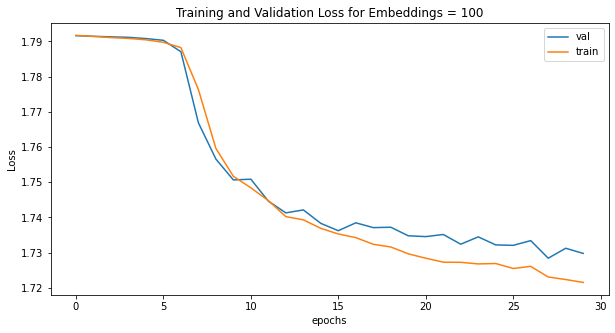

In [32]:
import matplotlib.pyplot as plt
%matplotlib inline 


plt.figure(figsize=(10,5))
plt.title("Training and Validation Loss for Embeddings = " + str(EMBEDDING_DIM))
plt.plot(val_losses,label="val")
plt.plot(train_losses,label="train")
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.legend()
plt.savefig("glove_loss_" + str(epochs)+"_"+ str(batch_size) + "_" + str(lr)+ "_" + str(EMBEDDING_DIM) + "_" + str(hidden) + ".jpg")
plt.show()

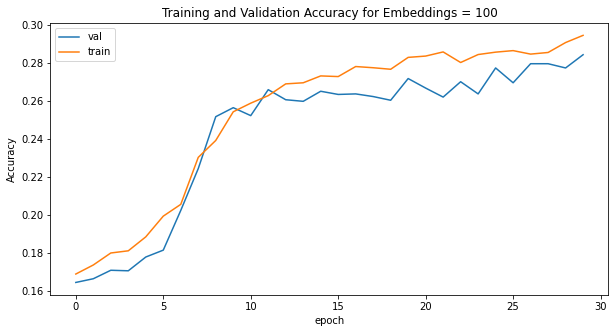

In [33]:
plt.figure(figsize=(10,5))
plt.title("Training and Validation Accuracy for Embeddings = " + str(EMBEDDING_DIM))
plt.plot(val_acc,label="val")
plt.plot(train_acc,label="train")
plt.xlabel("epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.savefig("glove_acc_" + str(epochs)+"_"+ str(batch_size) + "_" + str(lr)+ "_" + str(EMBEDDING_DIM) + "_" + str(hidden) + ".jpg")
plt.show()